In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

In [42]:
localpath = 'D:/leeky_ai/대회/건설기계오일/open/'

In [43]:
train = pd.read_csv(localpath+"train.csv")
test =  pd.read_csv(localpath+"test.csv")

In [ ]:
test

In [44]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [45]:
train = train.fillna(0)
test = test.fillna(0)

<AxesSubplot:>

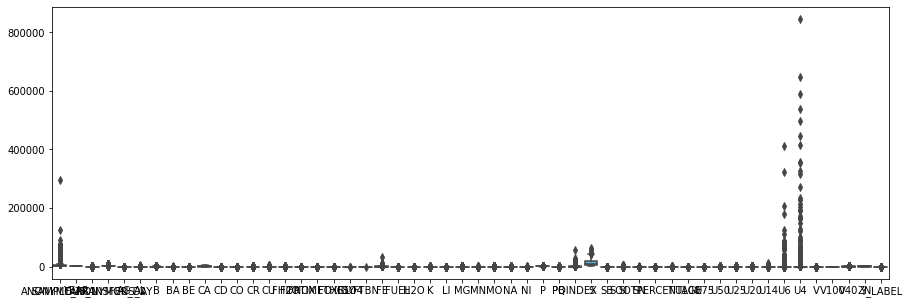

In [46]:
# train.describe()
plt.figure(figsize=(15,5))
sns.boxplot(data = train)

In [47]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


In [48]:
from sklearn.model_selection import train_test_split
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
test = test.drop(['ID'], axis = 1)
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [49]:
train_X.shape , val_X.shape, train_y.shape, val_y.shape

((11276, 52), (2819, 52), (11276,), (2819,))

In [50]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = RobustScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [51]:
test.head()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,0,-0.014439,9,0.0,0.0,0.0,-0.333333,-0.1875,-0.232,0.0,-0.5,-0.142857,0.0,-0.105882,0.0,0.0,-0.305215,0.527290
1,2,0.265952,4,0.0,0.0,0.0,0.333333,-0.1875,1.896,0.0,1.0,-0.142857,0.0,15.905882,1.0,0.0,0.240798,-0.470860
2,1,-0.112250,3,0.0,0.0,0.0,-0.333333,0.7500,-0.288,0.0,-0.5,-0.142857,0.0,-0.100000,0.0,0.0,-1.026074,0.178538
3,2,-0.381463,2,0.0,0.0,0.0,0.666667,0.0000,0.976,0.0,1.5,0.285714,0.0,46.935294,0.0,0.0,0.484663,-0.395005
4,1,2.795529,6,0.0,0.0,0.0,-0.333333,0.1250,-0.224,0.0,-0.5,-0.142857,0.0,-0.070588,0.0,0.0,-0.733129,-0.048104


# 지식증류(Knowledge Distillation)

In [136]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras

In [159]:
class Distillation(keras.Model):
    '''
        사전훈련된 교사모델
        훈련할 학생 모델
        손실함수
        소프트 학생 예측과 소프트 교사 라벨간의 차이에 대한 증류 손실 함수와 온도 스케일링 함수
        학생에게 가중치를 주는 alpha factor 요소와 증류 손실
        학생을 위한 최적화 도구(optimizer fo th student,선택옵션)와 퍼포먼스 측정을 위한 metrics
        
        교사와 학생모두에 대해서 forward를  수행하고 그 결과 alpha와(1-alpha)로 student_loss 와 distillation_lossby lapha 가중치로
        손실을 계산
        backward를 수행
    '''
    def __init__(self, student, teacher):
        super(Distillation,self).__init__()
        self.teacher = teacher
        self.student = student
            
    def compile(self
        ,optimizer='adam', metrics='accuracy'
                , student_loss_fn = keras.losses.binary_crossentropy
                , distillation_loss_fn = keras.losses.binary_crossentropy
                , alpha=0.1,temperature=3        
    ):
        super(Distillation,self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    
    def train_step(self, data):
        # 데이터 언 패킹
        tx,sx, y = data
        teacher_predictioons = self.teacher.predict(tx)
        # 자동미분
        with tf.GradientTape() as tape:
            # 학생의 전방 계산
            student_predictions = self.student.predict(sx)
            # losses 계산
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictioons / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha*student_loss+(1-self.alpha) * distillation_loss
        # Gradients 계산
        trainable_vars =  self.student.trainable_variables
        gradients = tape.gradient(loss,trainable_vars)
        
        # 가중치 업데이트
        self.optimizer.apply_gradients(zip(gradients,trainable_vars))
        
        # 메트릭 업데이트
        self.compiled_metrics.update_state(y,student_predictions)
        
        # 결과 리턴
        results = {m.name:m.result() for m in self.metrics}
        results.update(
            {"student_loss":student_loss,'distillation_loss' :distillation_loss}
        )
        return result
    def test_step(self, data):
        x,y = data
        y_prediction = self.student.predict(x)
        student_loss = self.student_loss_fn(y,y_prediction)
        
        self.compiled_metrics.update_state(y,y_prediction)
        
        results = {m.name:m.result() for m in self.metrics}
        results.update(
            {"student_loss":student_loss}
        )
        return results

In [56]:
train_X.shape

(11276, 52)

In [59]:
# 교사 모델 생성
teacher = keras.Sequential(
    [
    keras.Input(shape=(52,))
    ,layers.Dense(256)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(1024)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(256)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(1)
    ,layers.BatchNormalization()    
    ,layers.Activation(activation='sigmoid')
    ],
    name = 'teacher'
)

In [60]:
test.shape

(6041, 18)

In [91]:
# 학생 모델 생성
student = keras.Sequential(
    [
    keras.Input(shape=(18,))
    ,layers.Dense(128)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(512)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(128)
    ,layers.BatchNormalization()
    ,layers.LeakyReLU()
    ,layers.Dense(1)
    ,layers.BatchNormalization()    
    ,layers.Activation(activation='sigmoid')
    ],
    name = 'student'
)

In [87]:
# 후행비교를 위한 학생 복제
student_scatch = keras.models.clone_model(student)

In [88]:
# student.summary()

In [70]:
# 교사모델 훈련
teacher.compile(
    optimizer=keras.optimizers.Adam()
    ,loss = keras.losses.binary_crossentropy
    ,metrics=['acc']
)
callback = [
    keras.callbacks.EarlyStopping(patience = 7),
    keras.callbacks.ModelCheckpoint('teacher.model.keras',save_best_only=True)
]
teacher.fit(train_X,train_y,epochs=100,callbacks=callback, validation_data=(val_X,val_y))
teacher_loadmodel = keras.models.load_model('teacher.model.keras')
teacher_loadmodel.evaluate(val_X,val_y)

Epoch 1/100
353/353 [==============================] - 4s 9ms/step - loss: 0.2035 - acc: 0.9412 - val_loss: 0.2260 - val_acc: 0.9259
Epoch 2/100
353/353 [==============================] - 3s 9ms/step - loss: 0.1999 - acc: 0.9428 - val_loss: 0.2069 - val_acc: 0.9344
Epoch 3/100
353/353 [==============================] - 3s 8ms/step - loss: 0.2002 - acc: 0.9418 - val_loss: 0.2428 - val_acc: 0.9305
Epoch 4/100
353/353 [==============================] - 3s 8ms/step - loss: 0.1929 - acc: 0.9470 - val_loss: 0.2338 - val_acc: 0.9312
Epoch 5/100
353/353 [==============================] - 3s 8ms/step - loss: 0.1954 - acc: 0.9445 - val_loss: 0.2216 - val_acc: 0.9276
Epoch 6/100
353/353 [==============================] - 3s 9ms/step - loss: 0.1992 - acc: 0.9444 - val_loss: 0.2171 - val_acc: 0.9287
Epoch 7/100
353/353 [==============================] - 3s 9ms/step - loss: 0.1979 - acc: 0.9451 - val_loss: 0.2326 - val_acc: 0.9262
Epoch 8/100
353/353 [==============================] - 3s 9ms/step - 

[0.19697952270507812, 0.9404044151306152]

In [89]:
student_train_X =   train_X.loc[:,test_stage_features]
student_val_X = val_X.loc[:,test_stage_features]
student_train_X.shape, train_y.shape, student_val_X.shape, val_y.shape

((11276, 18), (11276,), (2819, 18), (2819,))

In [92]:
# 학생모델 훈련
student.compile(
    optimizer=keras.optimizers.Adam()
    ,loss = keras.losses.binary_crossentropy
    ,metrics=['acc']
)
callback = [
    keras.callbacks.EarlyStopping(patience = 7),
    keras.callbacks.ModelCheckpoint('student.model.keras',save_best_only=True)
]
student.fit(student_train_X,train_y,epochs=100,callbacks=callback, validation_data=(student_val_X,val_y))
student_loadmodel = keras.models.load_model('student.model.keras')
student_loadmodel.evaluate(student_val_X,val_y)

Epoch 1/100
353/353 [==============================] - 2s 4ms/step - loss: 0.6796 - acc: 0.6967 - val_loss: 0.6537 - val_acc: 0.8099
Epoch 2/100
353/353 [==============================] - 1s 4ms/step - loss: 0.5355 - acc: 0.8042 - val_loss: 0.4861 - val_acc: 0.8883
Epoch 3/100
353/353 [==============================] - 1s 4ms/step - loss: 0.4442 - acc: 0.8905 - val_loss: 0.4170 - val_acc: 0.9071
Epoch 4/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3884 - acc: 0.9112 - val_loss: 0.3751 - val_acc: 0.9092
Epoch 5/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3521 - acc: 0.9138 - val_loss: 0.3408 - val_acc: 0.9131
Epoch 6/100
353/353 [==============================] - 1s 4ms/step - loss: 0.3273 - acc: 0.9147 - val_loss: 0.3300 - val_acc: 0.9095
Epoch 7/100
353/353 [==============================] - 2s 5ms/step - loss: 0.3109 - acc: 0.9147 - val_loss: 0.3123 - val_acc: 0.9131
Epoch 8/100
353/353 [==============================] - 1s 4ms/step - 

[0.279834121465683, 0.9145087003707886]

In [163]:
# 일단 학생모델로 제출
test

<function __main__.test(a=0, b=1)>

In [160]:
distillation_model = Distillation(student_loadmodel,teacher_loadmodel)

In [161]:
distillation_model.compile()

In [162]:
distillation_model.train_step(
    (train_X,student_train_X,train_y)
)

353/353 [==============================] - 1s 2ms/step


LookupError: No gradient defined for operation'IteratorGetNext' (op type: IteratorGetNext). In general every operation must have an associated `@tf.RegisterGradient` for correct autodiff, which this op is lacking. If you want to pretend this operation is a constant in your program, you may insert `tf.stop_gradient`. This can be useful to silence the error in cases where you know gradients are not needed, e.g. the forward pass of tf.custom_gradient. Please see more details in https://www.tensorflow.org/api_docs/python/tf/custom_gradient.

In [146]:
teacher_loadmodel.predict(train_X)

353/353 [==============================] - 1s 3ms/step


array([[0.05695007],
       [0.04930936],
       [0.04033683],
       ...,
       [0.06371115],
       [0.05245271],
       [0.05571058]], dtype=float32)

In [134]:
x.shape, y.shape

((11276, 52), (11276,))

In [105]:
help(tf.keras.metrics.Accuracy)

Help on class Accuracy in module keras.metrics.metrics:

class Accuracy(keras.metrics.base_metric.MeanMetricWrapper)
 |  Accuracy(name='accuracy', dtype=None)
 |  
 |  Calculates how often predictions equal labels.
 |  
 |  This metric creates two local variables, `total` and `count` that are used
 |  to compute the frequency with which `y_pred` matches `y_true`. This
 |  frequency is ultimately returned as `binary accuracy`: an idempotent
 |  operation that simply divides `total` by `count`.
 |  
 |  If `sample_weight` is `None`, weights default to 1.
 |  Use `sample_weight` of 0 to mask values.
 |  
 |  Args:
 |    name: (Optional) string name of the metric instance.
 |    dtype: (Optional) data type of the metric result.
 |  
 |  Standalone usage:
 |  
 |  >>> m = tf.keras.metrics.Accuracy()
 |  >>> m.update_state([[1], [2], [3], [4]], [[0], [2], [3], [4]])
 |  >>> m.result().numpy()
 |  0.75
 |  
 |  >>> m.reset_state()
 |  >>> m.update_state([[1], [2], [3], [4]], [[0], [2], [3], [

In [ ]:
# optimizer, metrics, student_loss_fn, distillation_loss_fn

# Distillation_model.compile(

In [96]:
help(tf.keras.losses.sparse_categorical_crossentropy)

Help on function sparse_categorical_crossentropy in module keras.losses:

sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1, ignore_class=None)
    Computes the sparse categorical crossentropy loss.
    
    Standalone usage:
    
    >>> y_true = [1, 2]
    >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
    >>> loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> loss.numpy()
    array([0.0513, 2.303], dtype=float32)
    
    >>> y_true = [[[ 0,  2],
    ...            [-1, -1]],
    ...           [[ 0,  2],
    ...            [-1, -1]]]
    >>> y_pred = [[[[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]],
    ...             [[0.2, 0.5, 0.3], [0.0, 1.0, 0.0]]],
    ...           [[[1.0, 0.0, 0.0], [0.0, 0.5, 0.5]],
    ...            [[0.2, 0.5, 0.3], [0.0, 1.0, 0.0]]]]
    >>> loss = tf.keras.losses.sparse_categorical_crossentropy(
    ...   y_true, y_pred, ignore_class=-1)
    >>> loss.numpy()
    array([[[2.384